## Overturning Streamfunction panan-rOM3 analysis notebook

For `8km_jra_ryf_obc_Charrassin` experiment (MOM6-CICE6 panan 1/12th degree ~ 4km with no ice shelves)

**Note** Several non-standard uses of `esm_datastore`:

- `esm_datastore` was generated with a different branch to main to pick up incorrectly named files (see https://github.com/ACCESS-NRI/access-nri-intake-catalog/issues/459, thanks to Charles Turner for fixing this for me)
- Years 9 and 10 of this run used parallelised IO, and unfortunately the tiling resulted in NaNs along part of the y axis in these files. Therefore, we must use a preprocessing function that replaces these axes with that of an earlier time (month 0) (thanks to Jemma Jeffree for her help with this!)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from dask.distributed import Client
import intake
import cmocean as cm

In [2]:
client = Client(threads_per_worker = 1)
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38347 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/38347/status,
Dashboard: /proxy/38347/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43339,Workers: 0
Dashboard: /proxy/38347/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:45213,Total threads: 1
Dashboard: /proxy/44529/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:40911,


Load datastore

In [3]:
esm_datastore = intake.open_esm_datastore(
    "/g/data/ol01/cy8964/access-om3/archive/8km_jra_ryf_obc_Charrassin/experiment_datastore.json", 
    columns_with_iterables=[
            "variable",
            "variable_long_name",
            "variable_standard_name",
            "variable_cell_methods",
            "variable_units",
    ] # This is important
)

esm_datastore

,unique
filename,608
file_id,44
path,5088
filename_timestamp,131
frequency,3
start_date,240
end_date,241
variable,201
variable_long_name,183
variable_standard_name,39


List available diagnostics

In [4]:
variables = esm_datastore.unique().variable
print(variables)

['ANGLE', 'ANGLET', 'NCAT', 'VGRDa', 'VGRDb', 'VGRDi', 'VGRDs', 'aice', 'blkmask', 'congel', 'dvidtd', 'dvidtt', 'frazil', 'frzmlt', 'hi', 'hs', 'sifb', 'snoice', 'time', 'time_bounds', 'uvel', 'vvel', 'Tair_m', 'Tsfc_m', 'aice_m', 'aicen_m', 'albice_m', 'albsni_m', 'albsno_m', 'alidf_ai_m', 'alidr_ai_m', 'alvdf_ai_m', 'alvdr_ai_m', 'congel_m', 'daidtd_m', 'daidtt_m', 'divu_m', 'dvidtd_m', 'dvidtt_m', 'evap_ai_m', 'fcondtop_ai_m', 'fcondtopn_ai_m', 'fhocn_ai_m', 'flat_ai_m', 'flatn_ai_m', 'flwdn_m', 'flwup_ai_m', 'fmeltt_ai_m', 'fmelttn_ai_m', 'frazil_m', 'fresh_ai_m', 'frzmlt_m', 'fsalt_ai_m', 'fsalt_m', 'fsens_ai_m', 'fsensn_ai_m', 'fsurfn_ai_m', 'fswabs_ai_m', 'fswdn_m', 'fswthru_ai_m', 'fswup_m', 'hi_m', 'hs_m', 'ice_present_m', 'meltb_m', 'meltl_m', 'melts_m', 'meltt_m', 'opening_m', 'rain_ai_m', 'scale_factor_m', 'shear_m', 'sice_m', 'sifb_m', 'snoice_m', 'snow_ai_m', 'strairx_m', 'strairy_m', 'strcorx_m', 'strcory_m', 'strength_m', 'strintx_m', 'strinty_m', 'strocnx_m', 'strocny

Load month 0 specific datastore to get y axis info

In [5]:
mo0_esm_datastore = intake.open_esm_datastore(
    "/g/data/ol01/cy8964/access-om3/datastores/8km_jra_ryf_obc_Charrassin-output000/experiment_datastore.json", 
    columns_with_iterables=[
            "variable",
            "variable_long_name",
            "variable_standard_name",
            "variable_cell_methods",
            "variable_units",
    ] # This is important
)

ds_good_yh = mo0_esm_datastore.search(variable="umo_2d").to_dask(xarray_open_kwargs={'decode_timedelta':True})
good_yh_coords = ds_good_yh.yh.copy().load()
ds_good_yq = mo0_esm_datastore.search(variable="vmo_2d").to_dask(xarray_open_kwargs={'decode_timedelta':True})
good_yq_coords = ds_good_yq.yq.copy().load()
def reset_y_coords(ds): #thanks to Jemma Jeffree for helping make this work!!
    ds = ds.assign_coords({'yh':good_yh_coords})
    ds = ds.assign_coords({'yq':good_yq_coords})
    return ds

When loading data that has a y-axis, you need to use the `preprocess` (and likely `decode_timedelta` too) arguments:
```
esm_datastore.search(variable="").to_dask(preprocess=reset_y_coords,xarray_open_kwargs={'decode_timedelta':True})
```

### Loading other model data from the intake catalogue for comparison

Let's load in the mom6 panan01 and panan005 models, as well as ACCESS-OM2-01-RYF (potentially there is a more suitable one with more diagnostics starting from WOA but it's not on intake?)

In [6]:
catalog = intake.cat.access_nri

In [7]:
catalog.search(model="ACCESS-OM2-01", frequency="1mon",name="01deg_jra55v13_ryf9091")


,model,description,realm,frequency,variable
name,,,,,
01deg_jra55v13_ryf9091,{ACCESS-OM2-01},{0.1 degree ACCESS-OM2 global model configuration with JRA55-do v1.3 RYF9091 repeat year forcing (May 1990 to Apr 1991)},"{seaIce, ocean}",{1mon},"{ty_trans_int_z, xu_ocean, total_ocean_sfc_salt_flux_coupler, passive_weddell, total_ocean_swflx_vis, vocn_m, sens_heat, alvdf_ai_m, temp, yt_ocean, frazil_3d, ULON, salt_surface_ave, total_ocean_..."


In [8]:
'''
names of panant models
panant-01-zstar-ACCESSyr2
panant-005-zstar-ACCESSyr2
panant-0025-zstar-ACCESSyr2
'''
catalog.search(name = "panant-01-zstar-ACCESSyr2")


,model,description,realm,frequency,variable
name,,,,,
panant-01-zstar-ACCESSyr2,"{MOM6, SIS2}",{0.1 degree (MOM6+SIS2) Pan-Antarctic regional model configuration under 1990-1991 JRA55-do repeat year forcing.},"{seaIce, ocean}","{1mon, fx, 1day}","{uo, geolon, T_ady, Kd_BBL, geolon_u, zos, dv_dt_visc, deptho, PFu, rhopot2, geolat_c, yT, CAv, dyCu, intz_diffu_2d, xq, rhopot0, taux_bot, lrunoff, intz_diffv_2d, yq, geolon_c, precip, average_T2..."


# Plot overturning streamfunction averaged over years 9 and 10

Code gratefully stolen and modified from COSIMA Recipes - https://github.com/COSIMA/cosima-recipes/blob/main/Recipes/Appetisers-Easy/Overturning_Circulation.ipynb

Load data and use chunks to speed it up (~100GB )

In [9]:
panantrom3_vmo = esm_datastore.search(variable="vmo", frequency = '1mon').to_dask(preprocess=reset_y_coords,xarray_open_kwargs={'decode_timedelta':True,
                                                                                 'chunks' :{
        'time' : 2,
        'z_l' : 14,
        'yq' : 600,
        'xh' : 800,}})

# load old panan
panant01_vmo = catalog["panant-01-zstar-ACCESSyr2"].search(variable="vmo", frequency = '1mon').to_dask(xarray_open_kwargs={'decode_timedelta':True,
                                                                                                      'chunks' :{
        'time' : 2,
        'z_l' : 14,
        'yq' : 600,
        'xh' : 800,
    }})
panant005_vmo = catalog["panant-005-zstar-ACCESSyr2"].search(variable="vmo", frequency = '1mon').to_dask(xarray_open_kwargs={'decode_timedelta':True,
                                                                                                        'chunks':'auto'})

# load access-om2-01
accessom2_vmo = catalog["01deg_jra55v13_ryf9091"].search(frequency="1mon",variable = "ty_trans_rho").to_dask(xarray_open_kwargs={'decode_timedelta':True,
                                                                                                            'chunks' :{
        'time' : 2,
        'grid_yu_ocean' : 600,
        'grid_xt_ocean' : 800,
    }})

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/intake_esm/source.py:82: UserWarning: The specified chunks separate the stored chunks along dimension "xh" starting at index 800. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/intake_esm/source.py:82: UserWarning: The specified chunks separate the stored chunks along dimension "yq" starting at index 600. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/intake_esm/source.py:82: UserWarning: The specified chunks separate the stored chunks along dimension "xh" starting at index 800. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(url,

In [10]:
def plot_mom6_overturning_streamfunc(ax,vmo_in,title):
    print(title)
    vmax = 25
    vmin = -25
    
    max_value = vmax
    levels =  np.hstack((np.arange(-max_value, 0, 2), np.flip(-np.arange(-max_value, 0, 2))))
    cbarticks = np.hstack((np.flip(-np.arange(3, max_value, 6)), np.arange(3, max_value, 6)))
    
    #overturning streamfunc in years 9 and 10
    vmo_in = vmo_in.isel(time = np.arange(8*12,9*12+12))
    vmo_in = vmo_in.vmo.mean("time")
    #vmo_in = vmo_in.load()
    
    rho0 = 1035
    Psi =(vmo_in.sum('xh')/rho0).cumsum('rho2_l') -  (vmo_in.sum('xh')/rho0).sum('rho2_l')
    Psi = Psi.load()
    (Psi/1e6).plot.contourf(ax = ax, levels=levels,
                      cmap=cm.cm.curl,
                      extend='both',
                      cbar_kwargs={'shrink': 0.7, 'label': 'Sv', 'ticks': cbarticks})

    (Psi/1e6).plot.contour(ax = ax, levels=levels,
                         colors='k',
                         linewidths=0.25)
        
    ax.set_ylim((1037.5, 1033.5))
    ax.set_xlim(-80,-37.6)
    ax.set_ylabel('Potential Density (kg m$^{-3}$)')
    ax.set_xlabel('Latitude ($^\circ$N)')
    ax.set_title(title,fontsize = 14)
    print('Max negative streamfunction for '+title+' = '+str((Psi/1e6).sel(yq = slice(-90,-50)).min().values)+' Sv')
    print('Max negative streamfunction at 50S for '+title+' = '+str((Psi/1e6).sel(yq = -50, method = 'nearest').min().values)+' Sv')
    

In [11]:
def plot_mom5_overturning_streamfunc(ax,vmo_in,title):
    print(title)
    vmax = 25
    vmin = -25
    
    max_value = vmax
    levels =  np.hstack((np.arange(-max_value, 0, 2), np.flip(-np.arange(-max_value, 0, 2))))
    cbarticks = np.hstack((np.flip(-np.arange(3, max_value, 6)), np.arange(3, max_value, 6)))
    
    #overturning streamfunc in years 9 and 10
    vmo_in = vmo_in.isel(time = np.arange(8*12,9*12+12)).sel(grid_yu_ocean = slice(-90,-37.5))
    vmo_in = vmo_in.ty_trans_rho.mean("time")
    #vmo_in = vmo_in.load()
    
    rho0 = 1035
    Psi =(vmo_in.sum('grid_xt_ocean')/rho0).cumsum('potrho') -  (vmo_in.sum('grid_xt_ocean')/rho0).sum('potrho')
    Psi = Psi.load()
    
    (Psi/1e6).plot.contourf(ax = ax, levels=levels,
                      cmap=cm.cm.curl,
                      extend='both',
                      cbar_kwargs={'shrink': 0.7, 'label': 'Sv', 'ticks': cbarticks})

    (Psi/1e6).plot.contour(ax = ax, levels=levels,
                         colors='k',
                         linewidths=0.25)
        
    ax.set_ylim((1037.5, 1033.5))
    ax.set_xlim(-80,-37.6)
    ax.set_ylabel('Potential Density (kg m$^{-3}$)')
    ax.set_xlabel('Latitude ($^\circ$N)')
    ax.set_title(title,fontsize = 14)
    print('Max negative streamfunction for '+title+' = '+str((Psi/1e6).sel(grid_yu_ocean = slice(-90,-50)).min().values)+' Sv')
    print('Max negative streamfunction at 50S for '+title+' = '+str((Psi/1e6).sel(grid_yu_ocean = -50, method = 'nearest').min().values)+' Sv')

panant rom3 4km / 1/12th
Max negative streamfunction for panant rom3 4km / 1/12th = -20.59037971496582 Sv
Max negative streamfunction at 50S for panant rom3 4km / 1/12th = -20.056947708129883 Sv
panant 01
Max negative streamfunction for panant 01 = -25.98137855529785 Sv
Max negative streamfunction at 50S for panant 01 = -21.146175384521484 Sv
panant 005
Max negative streamfunction for panant 005 = -25.836231231689453 Sv
Max negative streamfunction at 50S for panant 005 = -21.732656478881836 Sv
ACCESS-OM2-01


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 15.24 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Max negative streamfunction for ACCESS-OM2-01 = -26.032066345214844 Sv
Max negative streamfunction at 50S for ACCESS-OM2-01 = -19.161720275878906 Sv


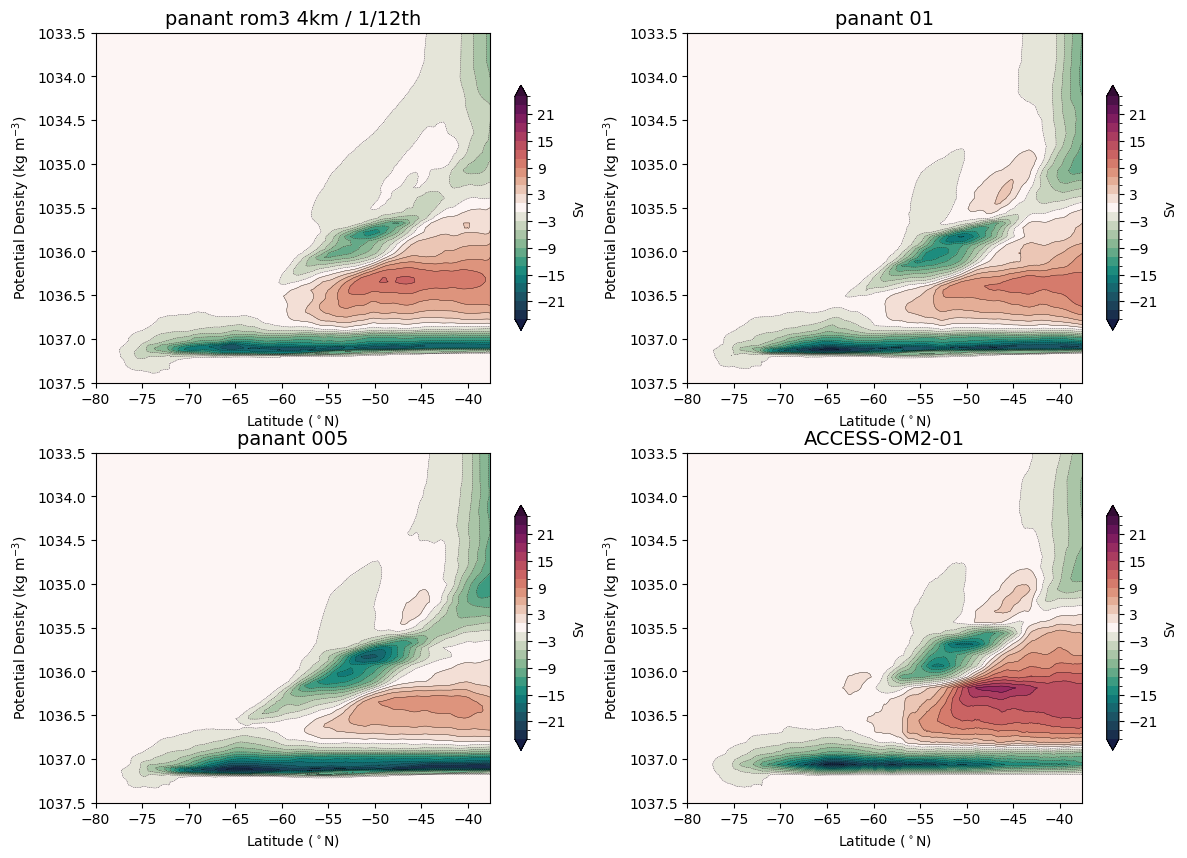

In [12]:
fig, axes1 = plt.subplots(ncols = 2, nrows = 2, figsize = (14,10))
axes = np.ravel(axes1)
plot_mom6_overturning_streamfunc(axes[0],panantrom3_vmo,'panant rom3 4km / 1/12th')
plot_mom6_overturning_streamfunc(axes[1],panant01_vmo,'panant 01')
plot_mom6_overturning_streamfunc(axes[2],panant005_vmo,'panant 005')
plot_mom5_overturning_streamfunc(axes[3],accessom2_vmo,'ACCESS-OM2-01')


# Plot max streamfunction at 50S as a timeseries

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 18.86 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


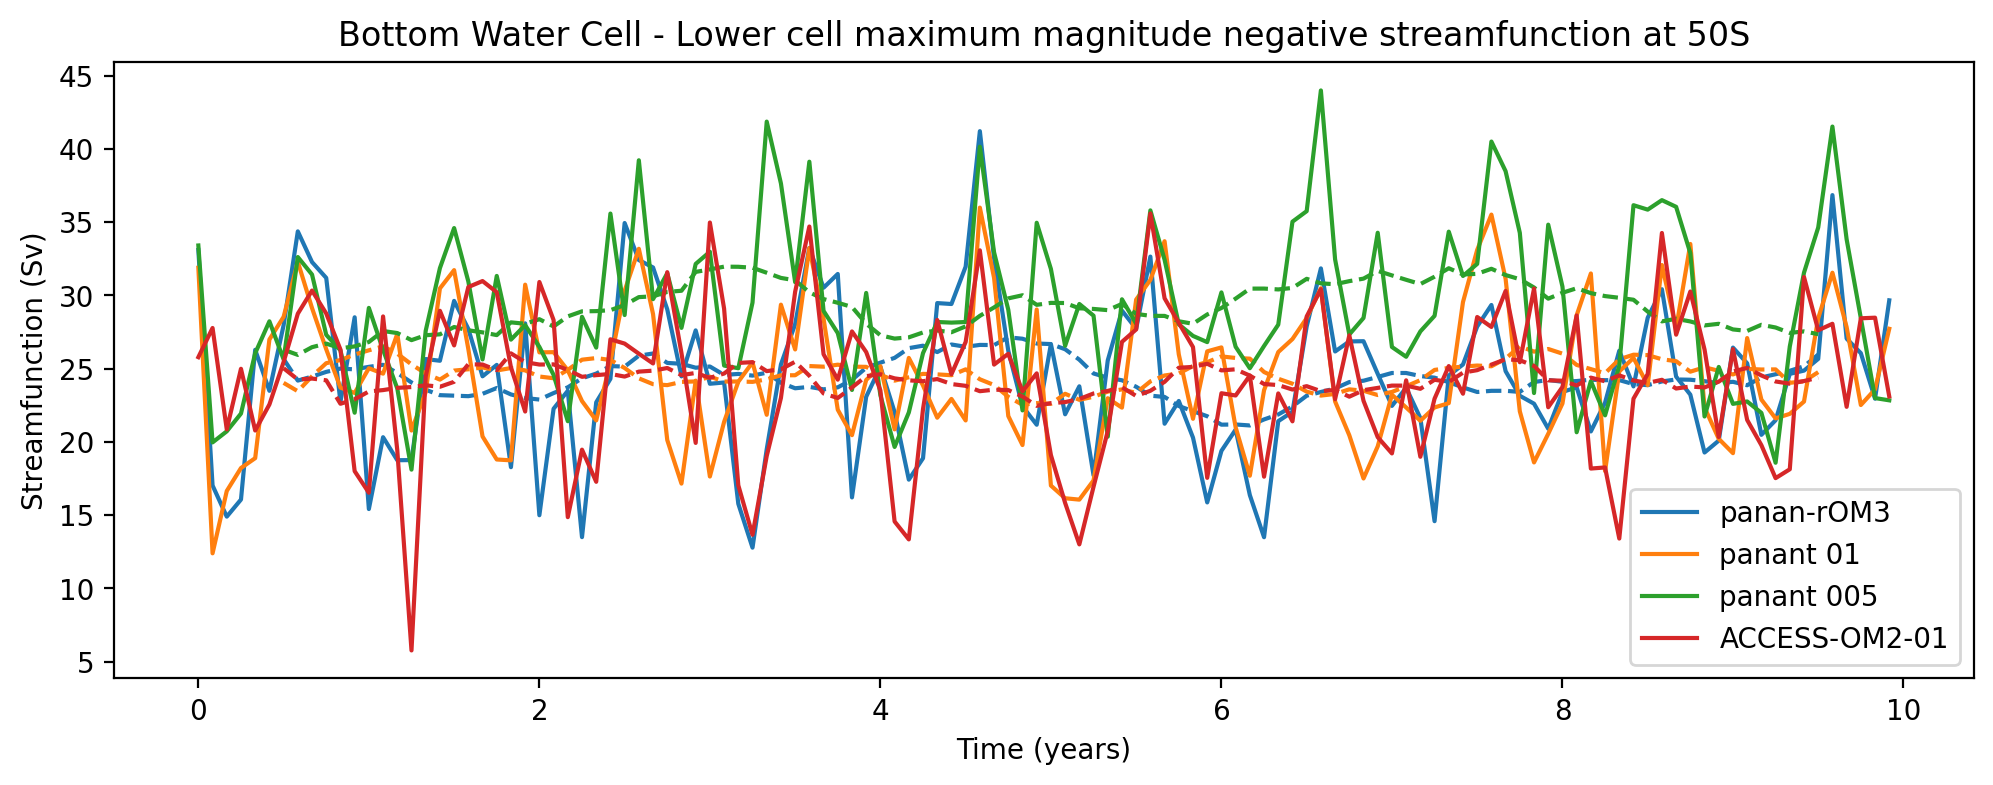

In [31]:
#Overturning streamfunction min strength at 50S
rho0 = 1035

#define figure
fig,axes = plt.subplots(figsize = (12,4),dpi = 200)

# plot new sim first
panantrom3_vmo_50S = panantrom3_vmo.isel(time = np.arange(9*12+12)).vmo.sel(yq = -50, method = 'nearest')
Psi =(panantrom3_vmo_50S.sum('xh')/rho0).cumsum('rho2_l') -  (panantrom3_vmo_50S.sum('xh')/rho0).sum('rho2_l')
BottomCellStrength = - Psi.min('rho2_l')/1e6
BottomCellStrength = BottomCellStrength.load()
plt.plot(np.arange(len(BottomCellStrength.time))/12, BottomCellStrength,label = 'panan-rOM3')
BottomCellStrengthroll = BottomCellStrength.rolling(time=12, center=True).mean()#.dropna("time")
plt.plot(np.arange(len(BottomCellStrength.time))/12, BottomCellStrengthroll,color = 'C0',linestyle = '--')

panant01_vmo_50S = panant01_vmo.isel(time = np.arange(9*12+12)).vmo.sel(yq = -50, method = 'nearest')
Psi =(panant01_vmo_50S.sum('xh')/rho0).cumsum('rho2_l') -  (panant01_vmo_50S.sum('xh')/rho0).sum('rho2_l')
BottomCellStrength = - Psi.min('rho2_l')/1e6
BottomCellStrength = BottomCellStrength.load()
plt.plot(np.arange(len(BottomCellStrength.time))/12, BottomCellStrength,label = 'panant 01')
BottomCellStrengthroll = BottomCellStrength.rolling(time=12, center=True).mean()#.dropna("time")
plt.plot(np.arange(len(BottomCellStrength.time))/12, BottomCellStrengthroll,color = 'C1',linestyle = '--')

panant005_vmo_50S = panant005_vmo.isel(time = np.arange(9*12+12)).vmo.sel(yq = -50, method = 'nearest')
Psi =(panant005_vmo_50S.sum('xh')/rho0).cumsum('rho2_l') -  (panant005_vmo_50S.sum('xh')/rho0).sum('rho2_l')
BottomCellStrength = - Psi.min('rho2_l')/1e6
BottomCellStrength = BottomCellStrength.load()
plt.plot(np.arange(len(BottomCellStrength.time))/12, BottomCellStrength,label = 'panant 005')
BottomCellStrengthroll = BottomCellStrength.rolling(time=12, center=True).mean()#.dropna("time")
plt.plot(np.arange(len(BottomCellStrength.time))/12, BottomCellStrengthroll,color = 'C2',linestyle = '--')

accessom2_vmo_50S = accessom2_vmo.ty_trans_rho.isel(time = np.arange(9*12+12)).sel(grid_yu_ocean = slice(-90,-37.5)).sel(grid_yu_ocean = -50,method = 'nearest')
Psi =(accessom2_vmo_50S.sum('grid_xt_ocean')/rho0).cumsum('potrho') -  (accessom2_vmo_50S.sum('grid_xt_ocean')/rho0).sum('potrho')
BottomCellStrength = - Psi.min('potrho')/1e6
BottomCellStrength = BottomCellStrength.load()
plt.plot(np.arange(len(BottomCellStrength.time))/12, BottomCellStrength,label = 'ACCESS-OM2-01')
BottomCellStrengthroll = BottomCellStrength.rolling(time=12, center=True).mean()#.dropna("time")
plt.plot(np.arange(len(BottomCellStrength.time))/12, BottomCellStrengthroll,color = 'C3',linestyle = '--')


plt.title('Bottom Water Cell - Lower cell maximum magnitude negative streamfunction at 50S')
plt.ylabel('Streamfunction (Sv)')
plt.xlabel('Time (years)')
plt.legend()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.07/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 18.86 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


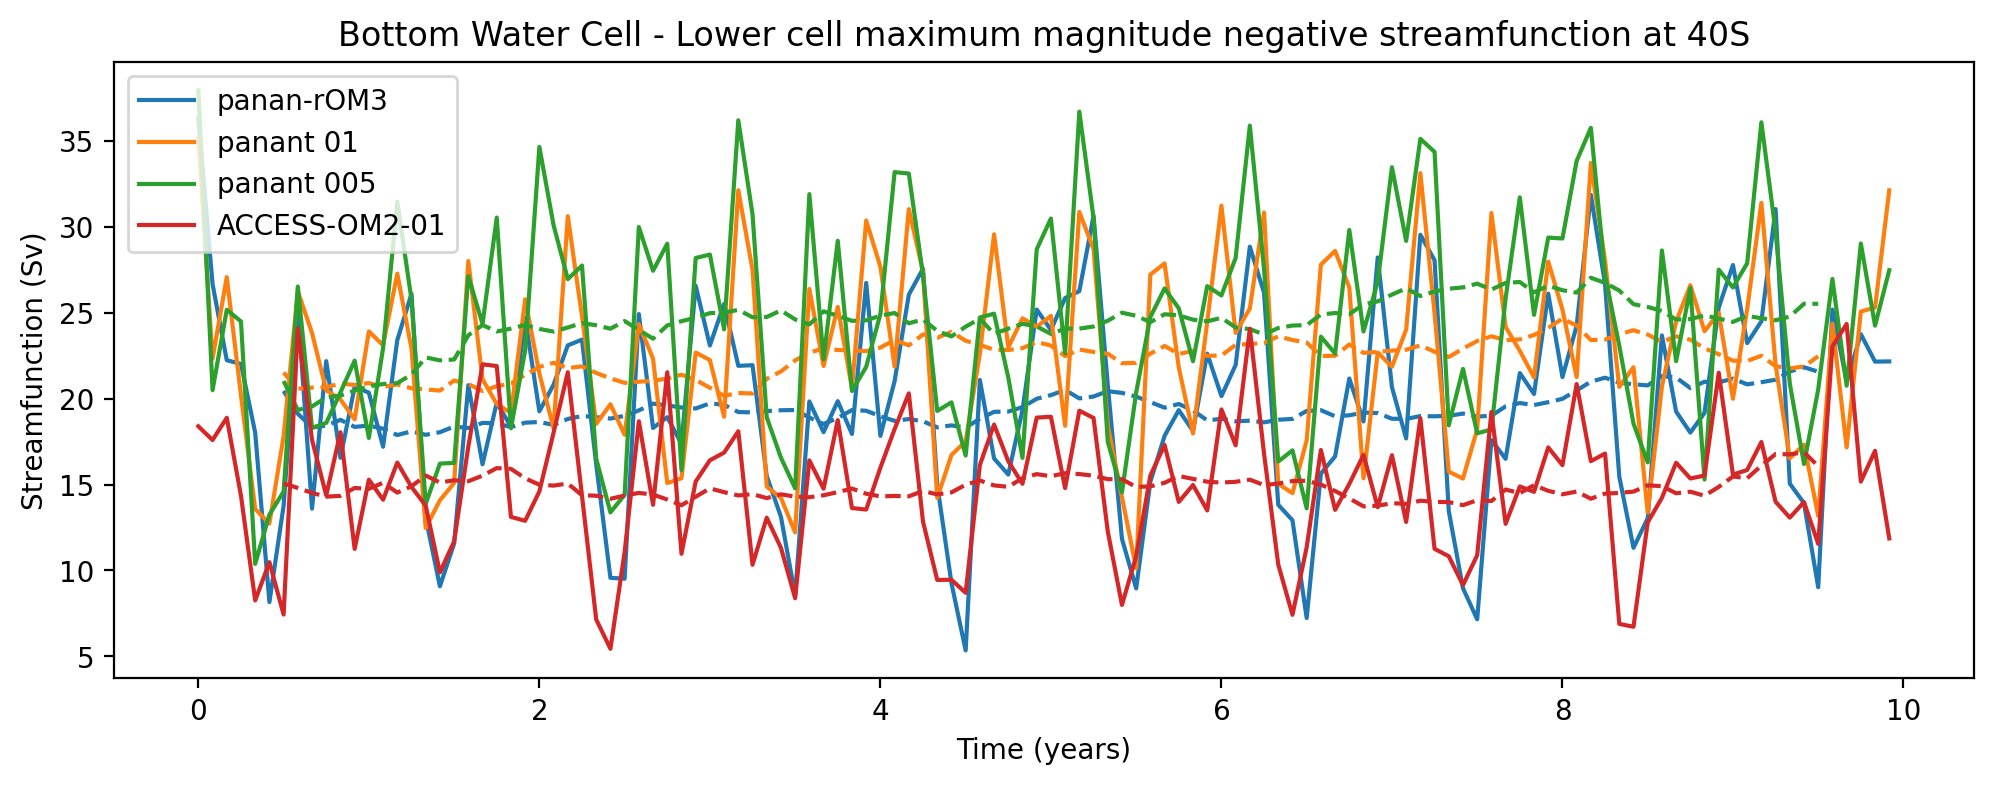

In [33]:
#Overturning streamfunction min strength at 50S
rho0 = 1035

#define figure
fig,axes = plt.subplots(figsize = (12,4),dpi = 200)

# plot new sim first
panantrom3_vmo_50S = panantrom3_vmo.isel(time = np.arange(9*12+12)).vmo.sel(yq = -40, method = 'nearest')
Psi =(panantrom3_vmo_50S.sum('xh')/rho0).cumsum('rho2_l') -  (panantrom3_vmo_50S.sum('xh')/rho0).sum('rho2_l')
BottomCellStrength = - Psi.min('rho2_l')/1e6
BottomCellStrength = BottomCellStrength.load()
plt.plot(np.arange(len(BottomCellStrength.time))/12, BottomCellStrength,label = 'panan-rOM3')
BottomCellStrengthroll = BottomCellStrength.rolling(time=12, center=True).mean()#.dropna("time")
plt.plot(np.arange(len(BottomCellStrength.time))/12, BottomCellStrengthroll,color = 'C0',linestyle = '--')


panant01_vmo_50S = panant01_vmo.isel(time = np.arange(9*12+12)).vmo.sel(yq = -40, method = 'nearest')
Psi =(panant01_vmo_50S.sum('xh')/rho0).cumsum('rho2_l') -  (panant01_vmo_50S.sum('xh')/rho0).sum('rho2_l')
BottomCellStrength = - Psi.min('rho2_l')/1e6
BottomCellStrength = BottomCellStrength.load()
plt.plot(np.arange(len(BottomCellStrength.time))/12, BottomCellStrength,label = 'panant 01')
BottomCellStrengthroll = BottomCellStrength.rolling(time=12, center=True).mean()#.dropna("time")
plt.plot(np.arange(len(BottomCellStrength.time))/12, BottomCellStrengthroll,color = 'C1',linestyle = '--')

panant005_vmo_50S = panant005_vmo.isel(time = np.arange(9*12+12)).vmo.sel(yq = -40, method = 'nearest')
Psi =(panant005_vmo_50S.sum('xh')/rho0).cumsum('rho2_l') -  (panant005_vmo_50S.sum('xh')/rho0).sum('rho2_l')
BottomCellStrength = - Psi.min('rho2_l')/1e6
BottomCellStrength = BottomCellStrength.load()
plt.plot(np.arange(len(BottomCellStrength.time))/12, BottomCellStrength,label = 'panant 005')
BottomCellStrengthroll = BottomCellStrength.rolling(time=12, center=True).mean()#.dropna("time")
plt.plot(np.arange(len(BottomCellStrength.time))/12, BottomCellStrengthroll,color = 'C2',linestyle = '--')

accessom2_vmo_50S = accessom2_vmo.ty_trans_rho.isel(time = np.arange(9*12+12)).sel(grid_yu_ocean = slice(-90,-37.5)).sel(grid_yu_ocean = -40,method = 'nearest')
Psi =(accessom2_vmo_50S.sum('grid_xt_ocean')/rho0).cumsum('potrho') -  (accessom2_vmo_50S.sum('grid_xt_ocean')/rho0).sum('potrho')
BottomCellStrength = - Psi.min('potrho')/1e6
BottomCellStrength = BottomCellStrength.load()
plt.plot(np.arange(len(BottomCellStrength.time))/12, BottomCellStrength,label = 'ACCESS-OM2-01')
BottomCellStrengthroll = BottomCellStrength.rolling(time=12, center=True).mean()#.dropna("time")
plt.plot(np.arange(len(BottomCellStrength.time))/12, BottomCellStrengthroll,color = 'C3',linestyle = '--')


plt.title('Bottom Water Cell - Lower cell maximum magnitude negative streamfunction at 40S')
plt.ylabel('Streamfunction (Sv)')
plt.xlabel('Time (years)')
plt.legend()